Successfully connected to database


/Users/pkrosniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


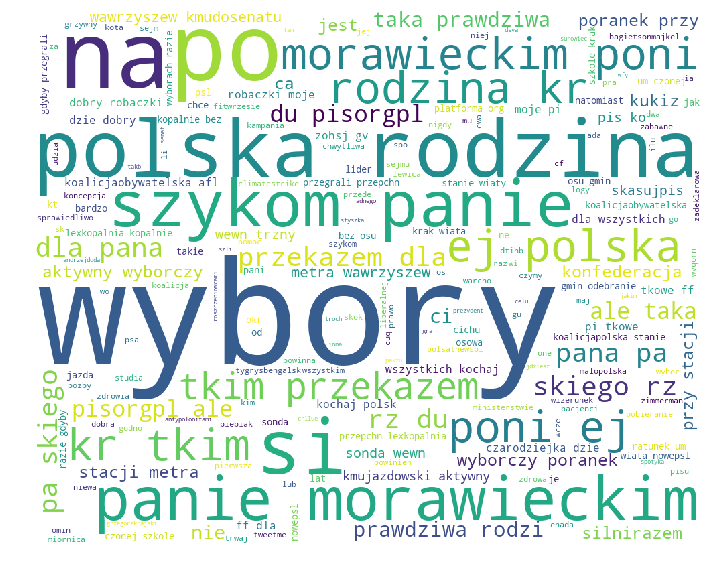



csv successfully saved. 

percentage of positive tweets: 1.36986301369863%
percentage of negative tweets: 1.36986301369863%
percentage of neutral tweets: 97.26027397260275%


In [12]:
import mysql.connector 
from mysql.connector import Error
import os
import re
import pandas as pd 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob



class TweetObject():


	def __init__(self, host, database, user):
		self.password = "Welcome124"
		self.host = "localhost"
		self.database = "twitterdb"
		self.user = "root"


	def MySQLConnect(self,query):
		"""
		Connects to database and extracts
		raw tweets and any other columns we
		need
		Parameters:
		----------------
		arg1: string: SQL query
		Returns: Pandas Dataframe
		----------------
		"""

		try:
			con = mysql.connector.connect(host = self.host, database = self.database, \
				user = self.user, password = self.password, charset = 'utf8')

			if con.is_connected():
				print("Successfully connected to database")

				cursor = con.cursor()
				query = query
				cursor.execute(query)

				data = cursor.fetchall()
				# store in dataframe
				df = pd.DataFrame(data,columns = ['date', 'tweet'])



		except Error as e:
			print(e)
		
		cursor.close()
		con.close()

		return df



	def clean_tweets(self, df):
	
		"""
		Takes raw tweets and cleans them
		so we can carry out analysis
		remove stopwords, punctuation,
		lower case, html, emoticons.
		This will be done using Regex
		? means option so colou?r matches
		both color and colour.
		"""

		# Do some text preprocessing
		stopword_list = stopwords.words('english')
		ps = PorterStemmer()
		df["clean_tweets"] = None
		df['len'] = None
		for i in range(0,len(df['tweet'])):
			# get rid of anythin that isnt a letter

			exclusion_list = ['[^a-zA-Z]','rt', 'http', 'co', 'RT']
			exclusions = '|'.join(exclusion_list)
			text = re.sub(exclusions, ' ' , df['tweet'][i])
			text = text.lower()
			words = text.split()
			words = [word for word in words if not word in stopword_list]
			 # only use stem of word
			#words = [ps.stem(word) for word in words]
			df['clean_tweets'][i] = ' '.join(words)


		# Create column with data length
		df['len'] = np.array([len(tweet) for tweet in data["clean_tweets"]])
			


		return df



	def sentiment(self, tweet):
		"""
		This function calculates sentiment
		on our cleaned tweets.
		Uses textblob to calculate polarity.
		Parameters:
		----------------
		arg1: takes in a tweet (row of dataframe)
		"""

		# need to improce
		analysis = TextBlob(tweet)
		if analysis.sentiment.polarity > 0:
			return 1
		elif analysis.sentiment.polarity == 0:
			return 0
		else:
			return -1




	def save_to_csv(self, df):
		"""
		Save cleaned data to a csv for further
		analysis.
		Parameters:
		----------------
		arg1: Pandas dataframe
		"""
		try:
			df.to_csv("clean_tweets.csv")
			print("\n")
			print("csv successfully saved. \n")

		
		except Error as e:
			print(e)
		



	def word_cloud(self, df):
		plt.subplots(figsize = (12,10))
		wordcloud = WordCloud(
				background_color = 'white',
				width = 1000,
				height = 800).generate(" ".join(df['clean_tweets']))
		plt.imshow(wordcloud)
		plt.axis('off')
		plt.show()





if __name__ == '__main__':

	t = TweetObject( host = 'localhost', database = 'twitterdb', user = 'root')

	data  = t.MySQLConnect("SELECT created_at, text FROM `Twitter`")
	data = t.clean_tweets(data)
	data['Sentiment'] = np.array([t.sentiment(x) for x in data['clean_tweets']])
	t.word_cloud(data)
	t.save_to_csv(data)
	
	pos_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] > 0]
	neg_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] < 0]
	neu_tweets = [tweet for index, tweet in enumerate(data["clean_tweets"]) if data["Sentiment"][index] == 0]

	#Print results
	print("percentage of positive tweets: {}%".format(100*(len(pos_tweets)/len(data['clean_tweets']))))
	print("percentage of negative tweets: {}%".format(100*(len(neg_tweets)/len(data['clean_tweets']))))
	print("percentage of neutral tweets: {}%".format(100*(len(neu_tweets)/len(data['clean_tweets']))))